The maximum curvature is 4.8 at a frequency of 0.95.
The selected curvature is 0.0004343188619951367 at a frequency of 0.10235310218990264 with an index of 25.


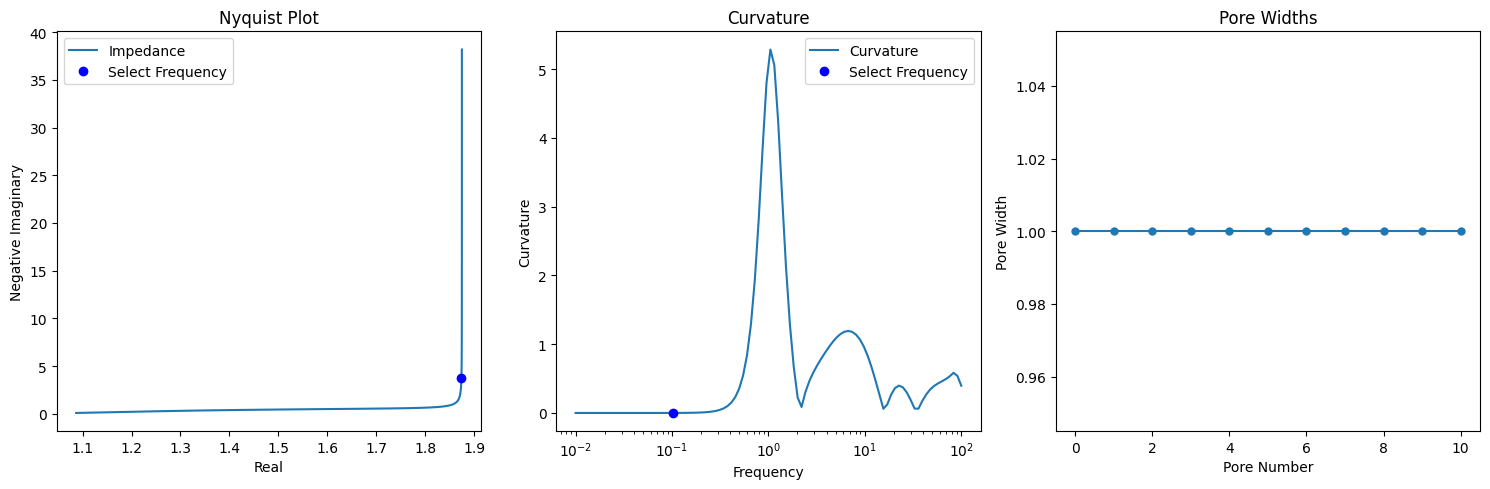

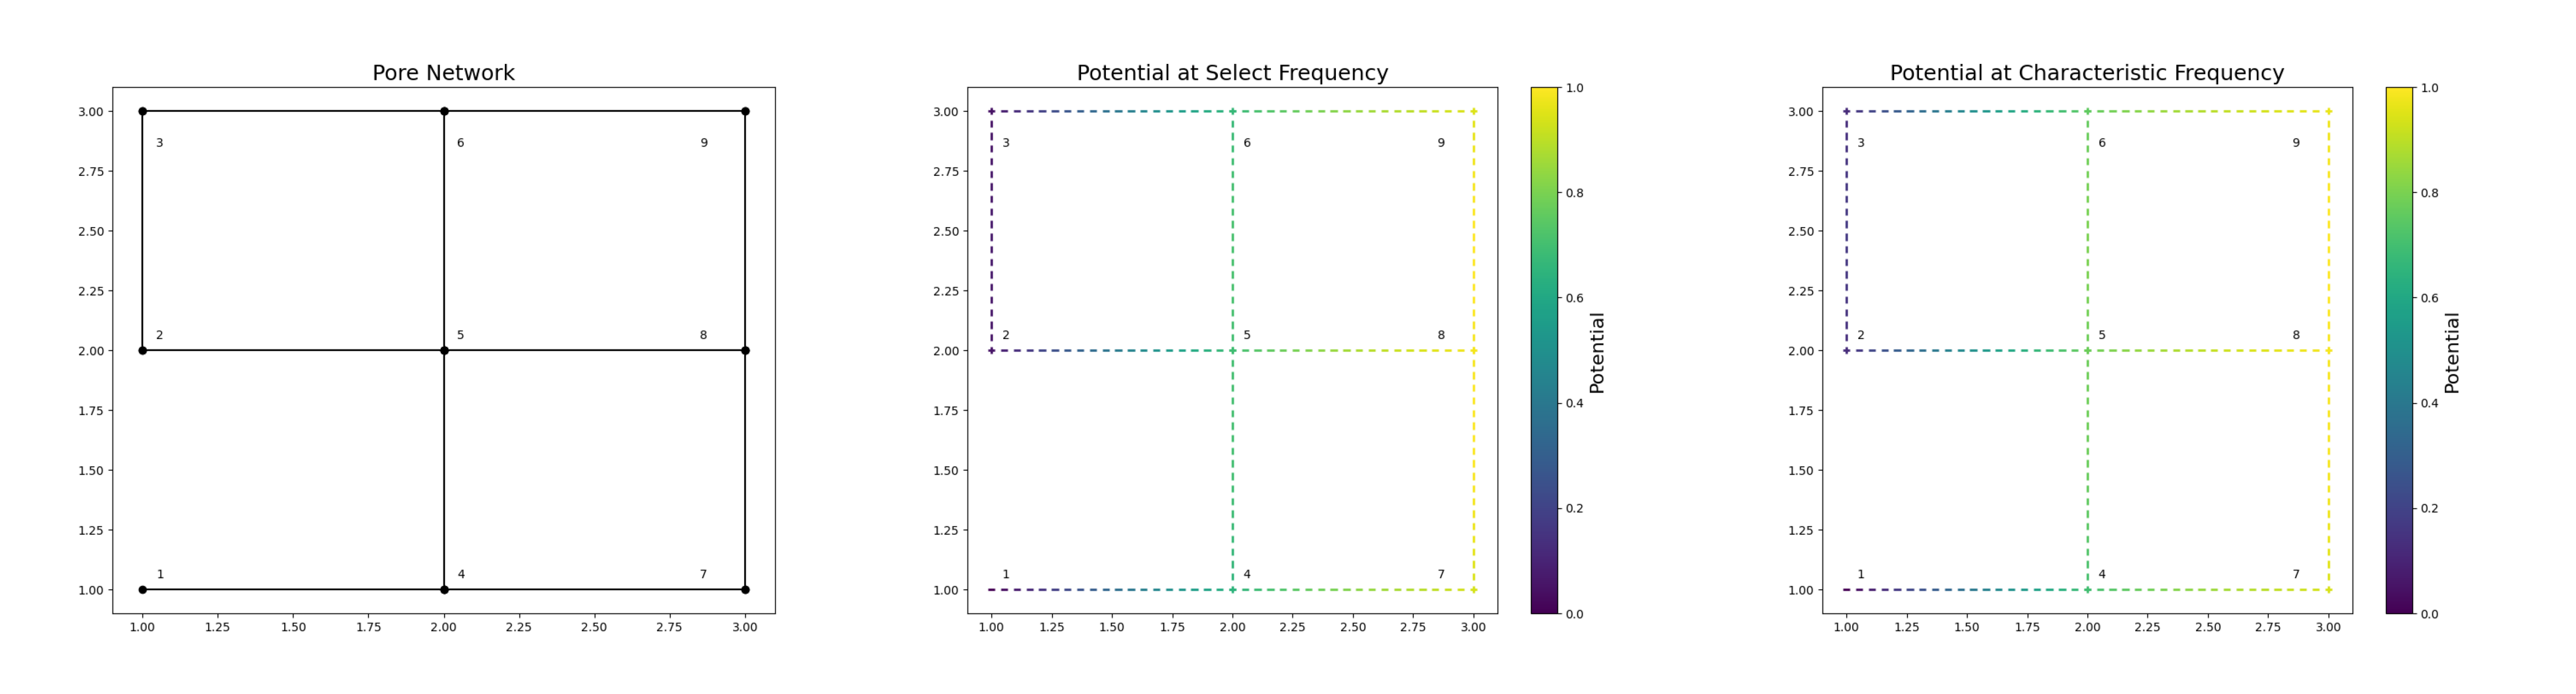

[1 0 1 1 1 1 1 1 1 1 1 1]


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.image as mpimg

def copy(Nx, Ny, grid):
    counter = 0

    fig, ax = plt.subplots(figsize=(10,8))
    for i in range(1, Nx + 1):
        for j in range(1, Ny + 1):
            site_no = Ny * (i - 1) + j
            if i == Nx and j == Ny:
                plt.annotate(xy=(i - Nx * 0.05, j - Ny * 0.05), text=site_no)
            elif i == Nx:
                plt.annotate(xy=(i - Nx * 0.05, j + Ny * 0.015), text=site_no)
            elif j == Ny:
                plt.annotate(xy=(i + Nx * 0.015, j - Ny * 0.05), text=site_no)
            else:
                plt.annotate(xy=(i + Nx * 0.015, j + Ny * 0.015), text=site_no)

            if i < Nx:
                if grid[counter] == 1:
                    plt.plot([i, i + 1], [j, j], 'ko-')
                counter += 1
            if j < Ny:
                if grid[counter] == 1:
                    plt.plot([i, i], [j, j + 1], 'ko-')
                counter += 1
    plt.title('Pore Network', fontsize=18)
    plt.savefig('copy.png')
    plt.close()

# def curvature(omega, Z):
#     Real = Z.real
#     Imag = Z.imag

#     # First derivatives
#     x_prime = np.gradient(Real, omega)
#     y_prime = np.gradient(Imag, omega)

#     # Second derivatives
#     x_double_prime = np.gradient(x_prime, omega)
#     y_double_prime = np.gradient(y_prime, omega)

#     # Calculating curvature of a parameteric function
#     numerator = x_prime * y_double_prime - y_prime * x_double_prime
#     denominator = (x_prime**2 + y_prime**2)**(3/2)
#     Kappa = np.abs(numerator / denominator)
#     Kappa = np.array(Kappa)
#     max_curvature = np.round(np.max(Kappa),2)
#     max_index = np.argmax(Kappa)

#     return Kappa, max_curvature, max_index

def curvature(omega, Z, window_size=3):
    Real = Z.real
    Imag = Z.imag
    DS = np.square(Real)-np.square(Imag)
    DS_index = np.argmax(DS)

    # First derivatives
    x_prime = np.gradient(Real, omega)
    y_prime = np.gradient(Imag, omega)

    # Second derivatives
    x_double_prime = np.gradient(x_prime, omega)
    y_double_prime = np.gradient(y_prime, omega)

    # Calculating curvature of a parametric function
    numerator = x_prime * y_double_prime - y_prime * x_double_prime
    denominator = (x_prime**2 + y_prime**2)**(3/2)
    Kappa = np.abs(numerator / denominator)
    Kappa = np.array(Kappa)

    # Define the range for searching local maximum
    start_index = max(0, DS_index - window_size)
    end_index = min(len(Kappa) - 1, DS_index + window_size)

    # Find the local maximum within the range
    max_curvature = np.round(np.max(Kappa[start_index:end_index]), 2)
    max_index = np.argmax(Kappa[start_index:end_index]) + start_index

    return Kappa, max_curvature, max_index

# def curvature(omega, Z):
#     Real = Z.real
#     Imag = Z.imag
#     DS = np.power(Real, 8) - np.square(Imag)
#     DS_index = np.argmax(DS)

#     # First derivatives
#     x_prime = np.gradient(Real, omega)
#     y_prime = np.gradient(Imag, omega)

#     # Second derivatives
#     x_double_prime = np.gradient(x_prime, omega)
#     y_double_prime = np.gradient(y_prime, omega)

#     # Calculating curvature of a parameteric function
#     numerator = x_prime * y_double_prime - y_prime * x_double_prime
#     denominator = (x_prime**2 + y_prime**2)**(3/2)
#     Kappa = np.abs(numerator / denominator)
#     Kappa = np.array(Kappa)
#     max_curvature = np.round(Kappa[DS_index],2)
#     max_index = DS_index

#     return Kappa, max_curvature, max_index

def custom(Nx, Ny, grid, mean, poly, std):
    counter = 0
    max_pores = Nx * (Ny - 1) + (Nx - 1) * Ny
    in_pt = []
    fin_pt = []
    a = []
    for i in range(1, Nx + 1):
        for j in range(1, Ny + 1):
          site_no = Ny * (i - 1) + j
          if i < Nx:
              if grid[counter] == 1:
                  in_pt.append(site_no)
                  fin_pt.append(site_no + Ny)
                  if poly == 0:
                      a.append(np.random.normal(mean, std))
                  elif poly == -1:
                      a.append(np.random.normal(mean*(1 - 0.1 * (i - 1)), std))
                  elif poly == 1:
                      a.append(np.random.normal(mean*(1 + 0.1 * (i - 1)), std))
              counter += 1
          if j < Ny:
              if grid[counter] == 1:
                  in_pt.append(site_no)
                  fin_pt.append(site_no + 1)
                  a.append(np.random.normal(mean, std))
              counter += 1
    starts = np.array(in_pt)
    ends = np.array(fin_pt)
    sites_repeated = in_pt + fin_pt
    sites = np.unique(np.array(sites_repeated))
    connections = np.array([sites_repeated.count(x) for x in set(sites_repeated)])
    a = np.array(a)
    pores = len(a)
    return starts, ends, sites, connections, a, pores

def F_solve(a, Bi, connections, ends, n, pores, sites, starts, w):
    D = a / np.tanh(a)
    deltax = 1 / (n - 1)
    A = np.zeros((pores * n, pores * n), dtype='complex_')
    b = np.zeros(pores * n, dtype='complex_')
    alpha = 1j * w * deltax ** 2 / D

    for i in range(pores):
        eq_no = (n - 2) * i
        pt_no = n * i

        for j in range(1, n - 1):
            A[j + eq_no - 1, j - 1 + pt_no] = 1
            A[j + eq_no - 1, j + pt_no] = -(2 + alpha[i])
            A[j + eq_no - 1, j + 1 + pt_no] = 1
            b[j + eq_no - 1] = -alpha[i]

    eq_no += n - 2

    for i in range(1, len(sites) + 1):
        starting_pores = np.where(starts == sites[i-1])[0] + 1
        ending_pores = np.where(ends == sites[i-1])[0] + 1
        starting_pt = (starting_pores - 1) * n
        ending_pt = n * ending_pores - 1
        all_pt = np.concatenate((starting_pt, ending_pt))

        for j in range(connections[i - 1]):
            if j > 0:
                A[j + eq_no, all_pt[j - 1]] = 1
                A[j + eq_no, all_pt[j]] = -1
            else:
                for k in range(len(starting_pores)):
                    A[j + eq_no, starting_pt[k]:(starting_pt[k] + 3)] = a[starting_pores[k] - 1] * np.array(
                        [3, -4, 1]) / (2 * deltax)
                for k in range(len(ending_pores)):
                    A[j + eq_no, (ending_pt[k] - 2):(ending_pt[k] + 1)] = a[ending_pores[k] - 1] * np.array(
                        [1, -4, 3]) / (2 * deltax)
                if sites[i-1] <= Ny:
                    A[j + eq_no, all_pt[0]] += Bi

        eq_no += connections[i - 1]

    F = np.linalg.solve(A, b)
    return F

def generate_pores(Nx, Ny, mean, p_elim, poly, std):
    max_pores = Nx * (Ny - 1) + (Nx - 1) * Ny
    in_pt = []
    fin_pt = []
    a = []
    grid = []

    for i in range(1, Nx + 1):
        for j in range(1, Ny + 1):
            site_no = Ny * (i - 1) + j
            if i == Nx and j == Ny:
                plt.annotate(xy=(i - Nx * 0.05, j - Ny * 0.05), text=site_no)
            elif i == Nx:
                plt.annotate(xy=(i - Nx * 0.05, j + Ny * 0.015), text=site_no)
            elif j == Ny:
                plt.annotate(xy=(i + Nx * 0.015, j - Ny * 0.05), text=site_no)
            else:
                plt.annotate(xy=(i + Nx * 0.015, j + Ny * 0.015), text=site_no)

            if i < Nx:
                if np.random.uniform(0, 1) > p_elim:
                    in_pt.append(site_no)
                    fin_pt.append(site_no + Ny)
                    if poly == 0:
                        a.append(np.random.normal(mean, std))
                    elif poly == -1:
                        a.append(np.random.normal(mean*(1 - 0.1 * (i - 1)), std))
                    elif poly == 1:
                        a.append(np.random.normal(mean*(1 + 0.1 * (i - 1)), std))
                    grid.append(1)
                    plt.plot([i, i + 1], [j, j], 'ko-')
                else:
                    grid.append(0)

            if j < Ny:
                if np.random.uniform(0, 1) > p_elim:
                    in_pt.append(site_no)
                    fin_pt.append(site_no + 1)
                    a.append(np.random.normal(mean, std))
                    grid.append(1)
                    plt.plot([i, i], [j, j + 1], 'ko-')
                else:
                    grid.append(0)

    plt.title('Initial Pores')
    plt.close()

    starts = np.array(in_pt)
    ends = np.array(fin_pt)
    sites_repeated = in_pt + fin_pt
    sites = np.unique(np.array(sites_repeated))
    connections = np.array([sites_repeated.count(x) for x in set(sites_repeated)])
    a = np.array(a)
    pores = len(a)
    grid = np.array(grid)

    return starts, ends, sites, connections, a, pores, grid

def horizontal_line(i, j, counter2, n, rgb):
    start_index = counter2 * n
    end_index = ((counter2 + 1) * n) - 1
    potential_slice = rgb[start_index:end_index + 1]
    x = np.linspace(i, i + 1, n)
    y = np.linspace(j, j, n)
    plt.scatter(x[:], y[:], c=potential_slice, marker='_', linewidths=2)

def impedance(Nx, Ny, Bi, grid, mean, n, omega, p_elim, poly, random, std, select):
    if random == 1:
        starts, ends, sites, connections, a, pores, grid = generate_pores(Nx, Ny, mean, p_elim, poly, std)
    elif random == 0:
        starts, ends, sites, connections, a, pores = custom(Nx, Ny, grid, mean, poly, std)
    D = a / np.tanh(a)
    deltax = 1 / (n - 1)
    Z = np.array([])
    potential = np.array([])

    for w in omega:
        F = F_solve(a, Bi, connections, ends, n, pores, sites, starts, w)
        Z = np.append(Z, 1 / F[0] / Bi)

    Kappa, max_curvature, max_index = curvature(omega, Z)
    F1 = F_solve(a, Bi, connections, ends, n, pores, sites, starts, omega[select])
    F2 = F_solve(a, Bi, connections, ends, n, pores, sites, starts, omega[max_index])
    return F1, F2, a, omega, grid, Kappa, max_curvature, max_index, n, Z, select

def plotting(Nx, Ny, Bi, grid, mean, n, omega, p_elim, poly, random, std, select):
    """
    Plot impedance, curvature, pore width, and regenerate pores.

    Args:
    - Nx (int): Number of columns.
    - Ny (int): Number of rows.
    - mean (float, optional): Mean of pore size distribution.
    - std (float, optional): Standard deviation of pore size distribution
    - p_elim (float, optional): Probability of pore elimination.
    """
    # Calculating impedance
    F1, F2, a, omega, grid, Kappa, max_curvature, max_index, n, Z, select = impedance(Nx, Ny, Bi, grid, mean, n, omega, p_elim, poly, random, std, select)

    # Curvature and characteristic frequency
    frequency = np.round(omega[max_index],2)
    print(f'The maximum curvature is {max_curvature} at a frequency of {frequency}.')
    print(f'The selected curvature is {Kappa[select]} at a frequency of {omega[select]} with an index of {select}.')

    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot impedance
    axes[0].plot(Z.real, -Z.imag, label='Impedance')
    # axes[0].plot(Z[max_index].real, -Z[max_index].imag, 'ro', label='Characteristic Frequency')
    axes[0].plot(Z[select].real, -Z[select].imag, 'bo', label='Select Frequency')
    axes[0].set_title('Nyquist Plot')
    axes[0].set_xlabel('Real')
    axes[0].set_ylabel('Negative Imaginary')
    axes[0].tick_params(axis='both', which='major')
    axes[0].legend()
    # # Set y-limit
    # axes[0].set_ylim([0, 100])  # Adjust the values as per your requirement

    # Plot curvature
    axes[1].plot(omega, Kappa, label='Curvature')
    # axes[1].plot(omega[max_index], Kappa[max_index], 'ro', label='Characteristic Frequency')
    axes[1].plot(omega[select], Kappa[select], 'bo', label='Select Frequency')
    axes[1].set_title('Curvature')
    axes[1].set_xlabel('Frequency')
    axes[1].set_ylabel('Curvature')
    axes[1].tick_params(axis='both', which='major')
    axes[1].set_xscale('log')
    axes[1].legend()

    # Plot pore width
    axes[2].plot(range(len(a)), a, marker='o', linestyle='-', markersize=5)
    axes[2].set_title('Pore Widths')
    axes[2].set_xlabel('Pore Number')
    axes[2].set_ylabel('Pore Width')
    axes[2].tick_params(axis='both', which='major')

    plt.tight_layout()
    plt.show()

    # Display potential plot
    regenerate_pores1(Nx, Ny, F1, grid, n)
    regenerate_pores2(Nx, Ny, F2, grid, n)

    # Load the saved figures
    img0 = mpimg.imread('copy.png')
    img1 = mpimg.imread('regenerate1.png')
    img2 = mpimg.imread('regenerate2.png')

    # Create a figure and arrange the images side by side
    plt.figure(figsize=(60, 30))

    # Display the first image on the left
    plt.subplot(1, 3, 1)
    plt.imshow(img0)
    plt.axis('off')  # Hide axes

    # Display the first image on the left
    plt.subplot(1, 3, 2)
    plt.imshow(img1)
    plt.axis('off')  # Hide axes

    # Display the second image on the right
    plt.subplot(1, 3, 3)
    plt.imshow(img2)
    plt.axis('off')  # Hide axes

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.00001)
    plt.show()

    return grid

def regenerate_pores1(Nx, Ny, F1, grid, n):
    copy(Nx, Ny, grid)
    counter = 0
    counter2 = 0
    values = F1[:].real
    min_val = np.min(values)
    max_val = np.max(values)
    memes = (values - min_val) / (max_val - min_val)

    colormap = plt.cm.viridis
    norm = mcolors.Normalize(vmin=memes.min(), vmax=memes.max())
    rgb = colormap(norm(memes))

    fig, ax = plt.subplots(figsize=(10,8))
    for i in range(1, Nx + 1):
        for j in range(1, Ny + 1):
            site_no = Ny * (i - 1) + j
            if i == Nx and j == Ny:
                plt.annotate(xy=(i - Nx * 0.05, j - Ny * 0.05), text=site_no)
            elif i == Nx:
                plt.annotate(xy=(i - Nx * 0.05, j + Ny * 0.015), text=site_no)
            elif j == Ny:
                plt.annotate(xy=(i + Nx * 0.015, j - Ny * 0.05), text=site_no)
            else:
                plt.annotate(xy=(i + Nx * 0.015, j + Ny * 0.015), text=site_no)

            if i < Nx:
                if grid[counter] == 1:
                    horizontal_line(i, j, counter2, n, rgb)
                    counter2 += 1
                counter += 1
            if j < Ny:
                if grid[counter] == 1:
                    vertical_line(i, j, counter2, n, rgb)
                    counter2 += 1
                counter += 1

    ax.set_title('Potential at Select Frequency', fontsize=18)
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Potential', fontsize=16)
    plt.savefig('regenerate1.png', dpi=100)
    plt.close()

def regenerate_pores2(Nx, Ny, F2, grid, n):
    copy(Nx, Ny, grid)
    counter = 0
    counter2 = 0
    values = F2[:].real
    min_val = np.min(values)
    max_val = np.max(values)
    memes = (values - min_val) / (max_val - min_val)

    colormap = plt.cm.viridis
    norm = mcolors.Normalize(vmin=memes.min(), vmax=memes.max())
    rgb = colormap(norm(memes))

    fig, ax = plt.subplots(figsize=(10,8))
    for i in range(1, Nx + 1):
        for j in range(1, Ny + 1):
            site_no = Ny * (i - 1) + j
            if i == Nx and j == Ny:
                plt.annotate(xy=(i - Nx * 0.05, j - Ny * 0.05), text=site_no)
            elif i == Nx:
                plt.annotate(xy=(i - Nx * 0.05, j + Ny * 0.015), text=site_no)
            elif j == Ny:
                plt.annotate(xy=(i + Nx * 0.015, j - Ny * 0.05), text=site_no)
            else:
                plt.annotate(xy=(i + Nx * 0.015, j + Ny * 0.015), text=site_no)

            if i < Nx:
                if grid[counter] == 1:
                    horizontal_line(i, j, counter2, n, rgb)
                    counter2 += 1
                counter += 1
            if j < Ny:
                if grid[counter] == 1:
                    vertical_line(i, j, counter2, n, rgb)
                    counter2 += 1
                counter += 1

    ax.set_title('Potential at Characteristic Frequency', fontsize=18)
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Potential', fontsize=16)
    plt.savefig('regenerate2.png', dpi=100)
    plt.close()

def vertical_line(i, j, counter2, n, rgb):
    start_index = counter2 * n
    end_index = ((counter2 + 1) * n) - 1
    potential_slice = rgb[start_index:end_index + 1]
    x = np.linspace(i, i, n)
    y = np.linspace(j, j + 1, n)
    plt.scatter(x[:], y[:], c=potential_slice, marker='|', linewidths=2)

# Unchanging parameters:
Bi = 1; n = 20; omega = np.logspace(-2,2,100);

# Dimensions of Network, Pore Width: Increasing(1)/Decreasing(-1)/Constant(0)
select = 25
Nx = 3
Ny = 3
poly = 0

# Pore Size
mean = 1
std = 0

# Custom (0) or Random (1) Network
random = 1
p_elim = 0.1
grid = np.array([1,0,0,0,0,1,1,1,0,0,1,0,0,1,1,1,0,1,1,0,1,1,0,0,0,0,0])

grid = plotting(Nx, Ny, Bi, grid, mean, n, omega, p_elim, poly, random, std, select)
print(grid)

In [ ]:
import numpy as np

Nx = 4
Ny = 5
max_pores = Nx * (Ny - 1) + (Nx - 1) * Ny

# Create an array filled with ones
array = np.ones(max_pores, dtype=int)

print(array)

grid = np.array([1,0,0,0,0,1,1,1,0,0,1,0,0,1,1,1,0,1,1,0,1,1,0,0,0,0,0])
grid = np.array([1,0,0,0,0,1,1,1,1,1,1,0,0,1,1,1,0,1,1,1,1,1,0,1,0,0,0])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
